### Tuberculosis-Detector

In [ ]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://download.pytorch.org/whl/cu117


In [ ]:
# Importing libraries
"""
Here, we have imported various libraries such as numpy, pandas, torch and torchvision for
image processing and machine learning tasks. It also sets the seed for reproducibility and sets
the device for computation (cuda or cpu).
"""

import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

# Initital configurations
SEED = 1234

def set_seeds(seed=1234):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # multi-GPU

# Set seeds for reproducibility
set_seeds(seed=SEED)

# Set device
cuda = True
device = torch.device("cuda" if (
    torch.cuda.is_available() and cuda) else "cpu")

print(device)

cuda


In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 13.4 MB/s eta 0:00:00


In [ ]:
# Setting up kaggle credentials
# ! Please upload kaggle.json file before running this script

!pip install  kaggle  # installing the kaggle package
!mkdir -p ~/.kaggle     # creating .kaggle folder where the key should be placed
!cp kaggle.json ~/.kaggle/  # move the key to the folder
!chmod 600 ~/.kaggle/kaggle.json  # change the permissions of the file.

In [ ]:

# Downloading dataset
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

# unzipping and removing zip file
!unzip tuberculosis-tb-chest-xray-dataset.zip
!rm -rf tuberculosis-tb-chest-xray-dataset.zip

 99% 657M/663M [00:11<00:00, 127MB/s]
100% 663M/663M [00:11<00:00, 61.1MB/s]
Archive:  tuberculosis-tb-chest-xray-dataset.zip
  inflating: TB_Chest_Radiography_Database/Normal.metadata.xlsx  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-10.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-100.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1000.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1001.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1002.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1003.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1004.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1005.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1006.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1007.png  
  inflating: TB_Chest_Radiography_Database/Normal/Normal-1008.png 

In [ ]:
# Preparing dataset folder and moving the files to it.

!mkdir datasets
!cp -r TB_Chest_Radiography_Database/Normal datasets/normal
!cp -r TB_Chest_Radiography_Database/Tuberculosis datasets/tuberculosis
!cp -r TB_Chest_Radiography_Database/Normal.metadata.xlsx datasets/normal.xlsx
!cp -r TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx datasets/tuberculosis.xlsx

!rm -rf TB_Chest_Radiography_Database


In [ ]:
# Checking excel sheets  and datasets
normal_df = pd.read_excel('datasets/normal.xlsx')
tuberculosis_df = pd.read_excel('datasets/tuberculosis.xlsx')

print("-------------------Dataset------------------")
print("Total Normal CXR Images: ",len(normal_df))
print("Total Tuberculosis CXR Images: ",len(tuberculosis_df))

-------------------Dataset------------------
Total Normal CXR Images:  3500
Total Tuberculosis CXR Images:  700


In [ ]:
# Splitting the datasets
"""
Here, we have logically divided the datasets into train, valid and test set in 70:15:15 ratio.
And also we have shuffled the dataset, so that both of the categories images gets mixed up.
"""
import glob
normal = glob.glob("datasets/normal/*")
tb = glob.glob("datasets/tuberculosis/*")

# Splitting in 70:15:15 ratio
train_path = normal[:2450] + tb[:490]
val_path = normal[2450:2975] + tb[490:595]
test_path = normal[2975:] + tb[595:]

# shuffling
random.shuffle(train_path)
random.shuffle(val_path)
random.shuffle(test_path)

print("-------------------Dataset------------------")
print("Total train CXR Images: ",len(train_path))
print("Total val CXR Images: ",len(val_path))
print("Total test CXR Images: ",len(test_path))

-------------------Dataset------------------
Total train CXR Images:  2940
Total val CXR Images:  630
Total test CXR Images:  630


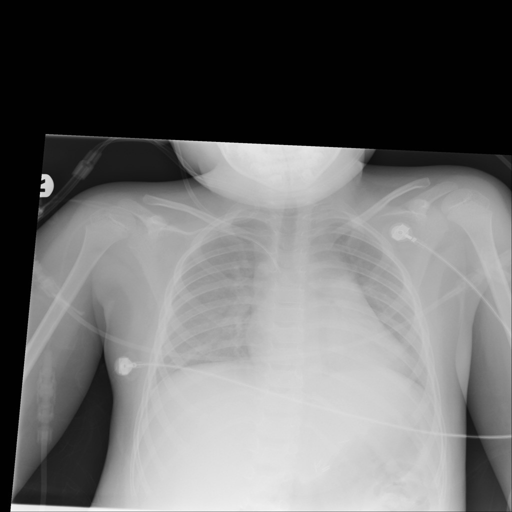

In [ ]:
Image.open(train_path[0])

In [ ]:

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.Resize(256),
        transforms.RandomRotation(degrees=15),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'others': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [ ]:
"""
Here, we have defined a custom dataset class 'TB_CXR_Dataset' which takes in a list of image paths
and an optional transform. The class assigns a label of 0 to images with "normal" in the path and a
label of 1 for the rest.

After that, we used this class to create datasets for train, validation, and test data using specific
transforms for each and created DataLoader objects for each dataset with batch size of 32.

"""
class TB_CXR_Dataset(Dataset):
    def __init__(self, images, transform=None):
        self.img_paths = images
        self.img_labels = [0 if "normal" in img else 1 for img in self.img_paths]
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        # get the image path and label for the specified index
        img_path = self.img_paths[idx]
        label = self.img_labels[idx]

        # load the image from the path
        image = Image.open(img_path)
        image = image.convert("RGB")

        # apply transform
        if self.transform:
            image = self.transform(image)

        # return the image and label as a tuple
        return image, label

# Dataset for train, valid and test
train_data = TB_CXR_Dataset(train_path, transform = data_transforms["train"])
valid_data = TB_CXR_Dataset(val_path, transform = data_transforms["others"])
test_data = TB_CXR_Dataset(test_path, transform = data_transforms["others"])

# Dataloader for train, valid and test
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)


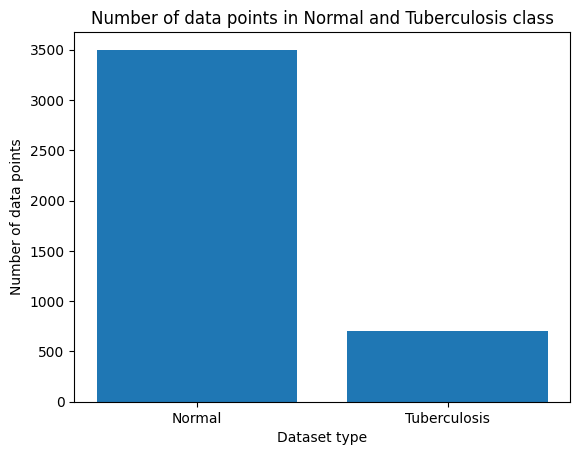

In [ ]:
import matplotlib.pyplot as plt
normal_size = len(normal_df)
Tuberculosis_size = len(tuberculosis_df)
sizes = [normal_size, Tuberculosis_size]

plt.bar(['Normal', 'Tuberculosis'], sizes)

plt.xlabel('Dataset type')
plt.ylabel('Number of data points')
plt.title('Number of data points in Normal and Tuberculosis class')

plt.show()

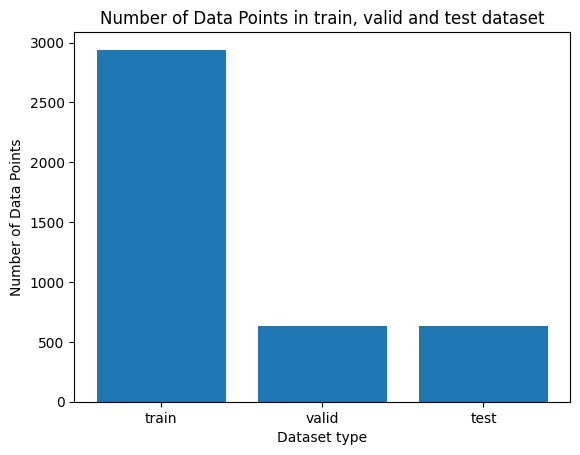

In [ ]:
# Get the number of data points in each dataset
train_size = len(train_data)
valid_size = len(valid_data)
test_size = len(test_data)

# Create a list of the sizes of each dataset
sizes = [train_size, valid_size, test_size]

# Create a bar plot with the sizes of the datasets
plt.bar(['train', 'valid', 'test'], sizes)

# Add labels and title to the plot
plt.xlabel('Dataset type')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points in train, valid and test dataset')

# Show the plot
plt.show()

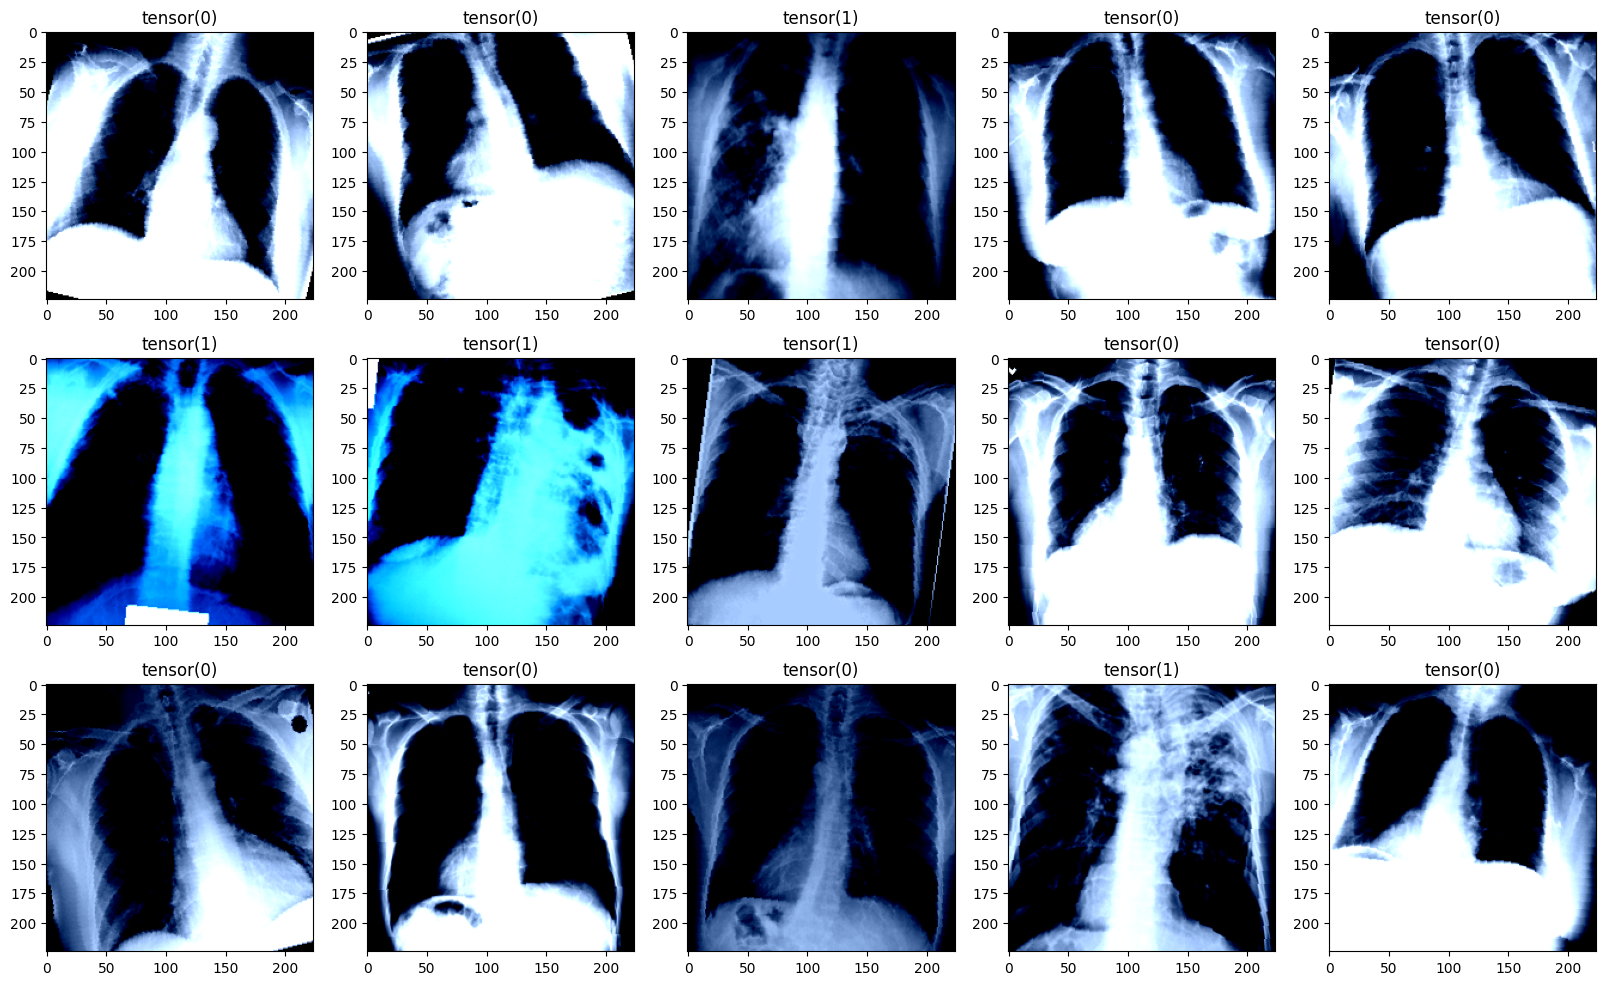

In [ ]:
# Load your data using a PyTorch dataloader
data, labels = next(iter(train_dataloader))

# Create a figure with a grid of subplots
fig, axs = plt.subplots(nrows=3, ncols=5,figsize=(20, 12))

# Plot the images in the subplots
for i, ax in enumerate(axs.flat):
    # Get the image and label for the current subplot
    image, label = data[i], labels[i]

    # Convert the image to a numpy array and plot it
    img = image.numpy().transpose((1, 2, 0))
    # mean = np.array([0.485, 0.456, 0.406])
    # std = np.array([0.229, 0.224, 0.225])
    # img = std * img + mean
    img = np.clip(img, 0, 1)

    ax.imshow(img)

    # Set the title of the subplot to the label
    ax.set_title(label)

# Show the plot
plt.show()

In [ ]:
from torchvision.models import densenet121,DenseNet121_Weights, DenseNet

#model architecture
class CXR_DenseNetModel(nn.Module):
  """DenseNet121 pretrained model definition."""
  def __init__(self, num_classes):
      super(CXR_DenseNetModel, self).__init__()

      self.model = torchvision.models.densenet121(pretrained=True)

      # Freeze the model's parameters
      for param in self.model.parameters():
          param.requires_grad = False

      # Replace the last linear layer of the model
      in_features = self.model.classifier.in_features
      self.model.classifier = nn.Sequential(
          nn.Linear(in_features, in_features // 2),
          nn.Dropout(0.5),
          nn.Linear(in_features // 2, in_features // 4),
          # nn.Dropout(0.5),
          nn.Linear(in_features // 4, in_features // 8),
          nn.Dropout(0.25),
          nn.Linear(in_features // 8, num_classes),
      )

  def forward(self, x):
      return self.model(x)

model = CXR_DenseNetModel(num_classes=2)


# set device
model = model.to(device)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 78.9MB/s]


CXR_DenseNetModel(
  (model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, mome

In [ ]:
# calculating weights for each classes

def class_weight(x,total):
  return 1 - (x/total)

total = 2450 + 490
class_weights = torch.tensor([class_weight(2450,total),class_weight(490,total)])



In [ ]:
# Define the Binary CrossEntropy with Logits loss function and Adam optimizer
loss_fn = nn.BCEWithLogitsLoss(weight = class_weights.to(device))
optimizer = optim.Adam(model.parameters(),lr=0.001)

# Decay LR by a factor of 0.1 every 3 epochs
# scheduler = lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [ ]:
from tqdm import tqdm
train_losses = []
valid_losses = []
train_acc = []
valid_acc=[]

def train(model, loss_fn, optimizer, num_epochs):

    for epoch in tqdm(range(num_epochs)):


        model.train()

        train_size = 0
        train_loss = 0.0
        train_accuracy = 0.0

        # Loop through the training dataloader
        for batch_idx, (images, labels) in enumerate(train_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels,2).float())

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            train_accuracy += torch.sum(preds == labels.data)

            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * images.size(0)
            train_size += images.size(0)

        # Validation
        # Set the model to evalutaion mode
        model.eval()

        valid_size = 0
        valid_loss = 0.0
        valid_accuracy = 0.0

        # Loop through the validing dataloader
        for batch_idx, (images, labels) in enumerate(valid_dataloader):
            images, labels = images.to(device), labels.to(device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = loss_fn(outputs, F.one_hot(labels,2).float())

            # Compute accuracy
            _, preds = torch.max(outputs, 1)
            valid_accuracy += torch.sum(preds == labels.data)

            # Backward pass
            loss.backward()
            optimizer.step()

            valid_loss += loss.item() * images.size(0)
            valid_size += images.size(0)

        # Print training and validation statistics
        train_loss = train_loss / train_size
        train_losses.append(train_loss)
        train_accuracy = train_accuracy / train_size
        train_acc.append(train_accuracy)

        valid_loss = valid_loss / valid_size
        valid_losses.append(valid_loss)

        valid_accuracy = valid_accuracy / valid_size
        valid_acc.append(valid_accuracy)


        print(f"\nTrain Loss: {train_loss:.3f},Train Accuracy: {train_accuracy:.3f}, Valid Loss: {valid_loss:.3f}, Valid Accuracy: {valid_accuracy:.2f}")

# Train the model
train(model, loss_fn, optimizer, num_epochs=25)

  4%|▍         | 1/25 [00:58<23:22, 58.45s/it]


Train Loss: 0.121,Train Accuracy: 0.911, Valid Loss: 0.034, Valid Accuracy: 0.98


  8%|▊         | 2/25 [01:52<21:20, 55.65s/it]


Train Loss: 0.070,Train Accuracy: 0.952, Valid Loss: 0.033, Valid Accuracy: 0.97


 12%|█▏        | 3/25 [02:44<19:48, 54.03s/it]


Train Loss: 0.053,Train Accuracy: 0.960, Valid Loss: 0.017, Valid Accuracy: 0.99


 16%|█▌        | 4/25 [03:43<19:34, 55.91s/it]


Train Loss: 0.059,Train Accuracy: 0.958, Valid Loss: 0.019, Valid Accuracy: 1.00


 20%|██        | 5/25 [04:36<18:22, 55.13s/it]


Train Loss: 0.052,Train Accuracy: 0.965, Valid Loss: 0.017, Valid Accuracy: 0.99


 24%|██▍       | 6/25 [05:28<17:07, 54.07s/it]


Train Loss: 0.049,Train Accuracy: 0.966, Valid Loss: 0.010, Valid Accuracy: 0.99


 28%|██▊       | 7/25 [06:20<16:00, 53.38s/it]


Train Loss: 0.046,Train Accuracy: 0.965, Valid Loss: 0.020, Valid Accuracy: 0.98


 32%|███▏      | 8/25 [07:12<14:59, 52.92s/it]


Train Loss: 0.045,Train Accuracy: 0.971, Valid Loss: 0.007, Valid Accuracy: 1.00


 36%|███▌      | 9/25 [08:04<14:01, 52.59s/it]


Train Loss: 0.059,Train Accuracy: 0.961, Valid Loss: 0.008, Valid Accuracy: 1.00


 40%|████      | 10/25 [08:56<13:05, 52.37s/it]


Train Loss: 0.041,Train Accuracy: 0.973, Valid Loss: 0.012, Valid Accuracy: 1.00


 44%|████▍     | 11/25 [09:49<12:14, 52.48s/it]


Train Loss: 0.048,Train Accuracy: 0.961, Valid Loss: 0.021, Valid Accuracy: 0.98


 48%|████▊     | 12/25 [10:41<11:20, 52.34s/it]


Train Loss: 0.041,Train Accuracy: 0.971, Valid Loss: 0.008, Valid Accuracy: 1.00


 52%|█████▏    | 13/25 [11:33<10:26, 52.25s/it]


Train Loss: 0.044,Train Accuracy: 0.966, Valid Loss: 0.019, Valid Accuracy: 0.99


 56%|█████▌    | 14/25 [12:25<09:34, 52.24s/it]


Train Loss: 0.036,Train Accuracy: 0.978, Valid Loss: 0.007, Valid Accuracy: 1.00


 60%|██████    | 15/25 [13:17<08:42, 52.28s/it]


Train Loss: 0.041,Train Accuracy: 0.976, Valid Loss: 0.007, Valid Accuracy: 1.00


 64%|██████▍   | 16/25 [14:09<07:50, 52.25s/it]


Train Loss: 0.040,Train Accuracy: 0.972, Valid Loss: 0.023, Valid Accuracy: 0.99


 68%|██████▊   | 17/25 [15:02<06:59, 52.43s/it]


Train Loss: 0.047,Train Accuracy: 0.969, Valid Loss: 0.008, Valid Accuracy: 1.00


 72%|███████▏  | 18/25 [15:54<06:06, 52.35s/it]


Train Loss: 0.042,Train Accuracy: 0.970, Valid Loss: 0.019, Valid Accuracy: 0.98


 76%|███████▌  | 19/25 [16:47<05:13, 52.31s/it]


Train Loss: 0.037,Train Accuracy: 0.976, Valid Loss: 0.009, Valid Accuracy: 0.99


 80%|████████  | 20/25 [17:39<04:21, 52.24s/it]


Train Loss: 0.037,Train Accuracy: 0.979, Valid Loss: 0.011, Valid Accuracy: 0.99


 84%|████████▍ | 21/25 [18:30<03:28, 52.08s/it]


Train Loss: 0.047,Train Accuracy: 0.967, Valid Loss: 0.010, Valid Accuracy: 1.00


 88%|████████▊ | 22/25 [19:22<02:35, 51.97s/it]


Train Loss: 0.041,Train Accuracy: 0.974, Valid Loss: 0.012, Valid Accuracy: 0.99


 92%|█████████▏| 23/25 [20:14<01:44, 52.05s/it]


Train Loss: 0.059,Train Accuracy: 0.964, Valid Loss: 0.003, Valid Accuracy: 1.00


 96%|█████████▌| 24/25 [21:06<00:51, 51.94s/it]


Train Loss: 0.041,Train Accuracy: 0.974, Valid Loss: 0.007, Valid Accuracy: 1.00


100%|██████████| 25/25 [21:58<00:00, 52.74s/it]


Train Loss: 0.037,Train Accuracy: 0.977, Valid Loss: 0.007, Valid Accuracy: 1.00


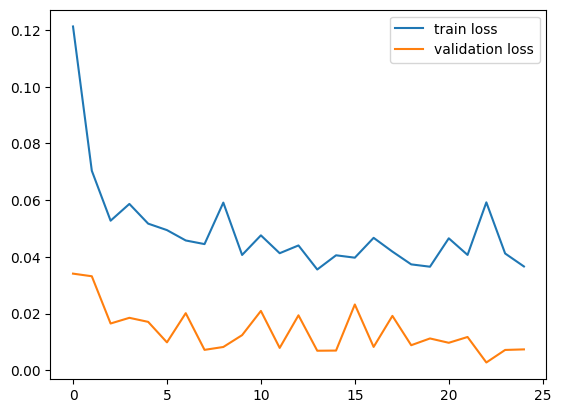

In [ ]:
# plot train and test losses
plt.plot(train_losses, label='train loss')
plt.plot(valid_losses, label='validation loss')
plt.legend()
plt.show()

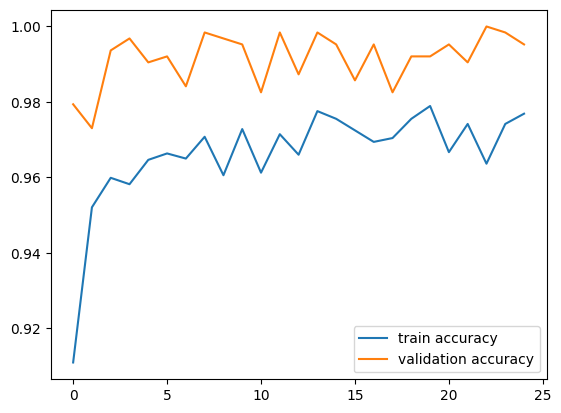

In [ ]:
# plot train and test acc
train_acc_np= np.array([x.cpu().numpy() for x in train_acc])
valid_acc_np= np.array([x.cpu().numpy() for x in valid_acc])

plt.plot(train_acc_np, label='train accuracy')
plt.plot(valid_acc_np, label='validation accuracy')
plt.legend()
plt.show()


In [ ]:
# Evaluation on test set
y_true = []
y_hat = []

test_size = 0
test_loss = 0.0
test_accuracy = 0.0
# Loop through the testing dataloader
for batch_idx, (images, labels) in enumerate(test_dataloader):
    images, labels = images.to(device), labels.to(device)

    # Zero the gradients
    optimizer.zero_grad()

    # Forward pass
    outputs = model(images)
    loss = loss_fn(outputs, F.one_hot(labels,2).float())

    # Compute accuracy
    _, preds = torch.max(outputs, 1)
    test_accuracy += torch.sum(preds == labels.data)

    y_true.extend(labels.detach().cpu().numpy().tolist())
    y_hat.extend(preds.detach().cpu().numpy().tolist())

    # Backward pass
    loss.backward()
    optimizer.step()

    test_loss += loss.item() * images.size(0)
    test_size += images.size(0)

In [ ]:
import torchmetrics
from torchmetrics.classification import BinaryAccuracy, BinaryAUROC, BinaryF1Score
from mlxtend.plotting import plot_confusion_matrix

metrics_acc = BinaryAccuracy()
metric_auroc = BinaryAUROC(thresholds=None)
metric_f1 = BinaryF1Score()

target = torch.tensor(y_true)
preds = torch.tensor(y_hat)

# Accuracy
acc = metrics_acc(preds, target)

# AUROC
auroc = metric_auroc(preds, target)

# F1 Score
f1 = metric_f1(preds, target)

print("Test Accuracy: ", acc)
print("Test AUROC: ", auroc)
print("Test F1: ", f1)

Test Accuracy:  tensor(0.9857)
Test AUROC:  tensor(0.9762)
Test F1:  tensor(0.9573)


In [ ]:
# Classification Report

from sklearn.metrics import classification_report
target_names = ['normal', 'tuberculosis']
print(classification_report(y_true, y_hat, target_names=target_names))

              precision    recall  f1-score   support

      normal       0.99      0.99      0.99       525
tuberculosis       0.95      0.96      0.96       105

    accuracy                           0.99       630
   macro avg       0.97      0.98      0.97       630
weighted avg       0.99      0.99      0.99       630



In [ ]:
from sklearn.metrics import confusion_matrix

# Order of the input parameters is important:
# first param is the actual output values
# second param is what our model predicted
conf_matrix = confusion_matrix(y_true, y_hat)

conf_matrix


array([[520,   5],
       [  4, 101]])

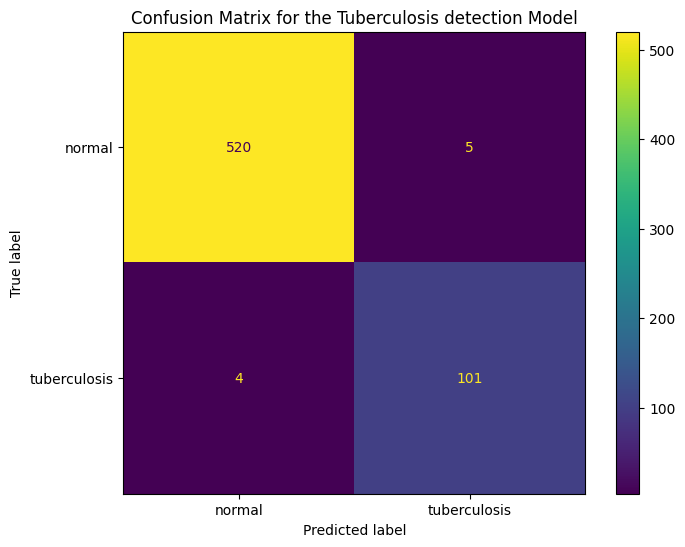

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)

# initialize using the raw 2D confusion matrix
# and output labels (in our case, it's 0 and 1)
display = ConfusionMatrixDisplay(conf_matrix, display_labels=['normal', 'tuberculosis'])

# set the plot title using the axes object
ax.set(title='Confusion Matrix for the Tuberculosis detection Model')

# show the plot.
# Pass the parameter ax to show customizations (ex. title)
display.plot(ax=ax);

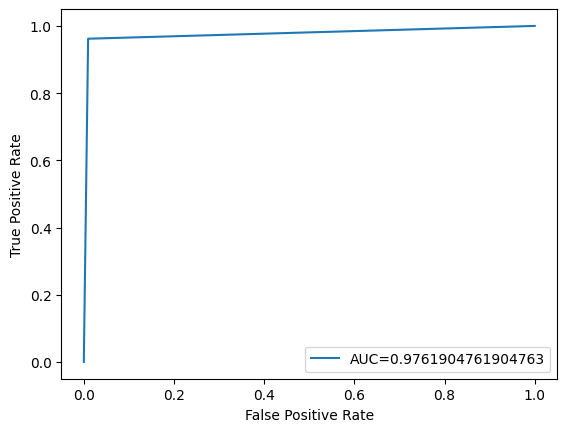

In [ ]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_true,  y_hat)
auc = metrics.roc_auc_score(y_true, y_hat)

#create ROC curve
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:

from pathlib import Path

# create model directory path
MODEL_PATH = Path('/content/drive/MyDrive/TubersavedModel')
MODEL_PATH.mkdir(parents = True,
                 exist_ok = True)

# create model save
MODEL_NAME = '01_tuberculosis_model.pth'
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME



# save the entire model
print(f'saving the entire model to :{MODEL_SAVE_PATH}')
torch.save(model, MODEL_SAVE_PATH)


saving the entire model to :/content/drive/MyDrive/TubersavedModel/01_tuberculosis_model.pth


In [ ]:
# loading model
PATH = "/content/drive/MyDrive/TubersavedModel/01_tuberculosis_model.pth"
model = torch.load(PATH,map_location=torch.device('cpu'))

In [ ]:
!pip install onnx

In [ ]:
# saving the model in onnx format
import torch.onnx

 # set the model to inference mode
model.eval()

# Input to the model
x = torch.randn(1, 3, 224, 224, requires_grad=True)

input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model,
                 x,
                 "/content/drive/MyDrive/TubersavedModel/tuberModel.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )


============= Diagnostic Run torch.onnx.export version 2.0.1+cu118 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [ ]:
from PIL import Image
import torchvision.transforms as transforms

img = Image.open("datasets/tuberculosis/Tuberculosis-1.png")

transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
img = transform(img)
img = img.unsqueeze_(0)

In [ ]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image


In [ ]:
!pip install torch torchvision onnxruntime


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.4 MB/s eta 0:00:00


In [ ]:
import onnxruntime

In [ ]:
model_path = 'tuberModel.onnx'
session = onnxruntime.InferenceSession(model_path)


In [ ]:
image_path = 'image.jpg'
image = Image.open(image_path).convert("RGB")

# Define the transformation sequence
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Apply the transformations
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)


In [ ]:
input_array = input_batch.numpy()


In [ ]:
input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name

predictions = session.run([output_name], {input_name: input_array})


In [ ]:
predicted_class = np.argmax(predictions[0])
print("Predicted class index:", predicted_class)


Predicted class index: 1


In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image

# Load the trained model
model = torch.load('01_tuberculosis_model.pth')
model.eval()

# Check if a GPU is available and move the model to the GPU device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the transformation sequence
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load and preprocess the input image
image_path = 'image3.jpg'
image = Image.open(image_path).convert("RGB")
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)

# Move the input tensor to the same device as the model
input_batch = input_batch.to(device)

# Make predictions
with torch.no_grad():
    output = model(input_batch)

# Get the predicted class probabilities
probabilities = torch.softmax(output, dim=1)[0]
tb_probability = probabilities[1].item()  # Probability of TB class

# Define a threshold for classification
threshold = 0.5

# Classify based on the threshold
if tb_probability >= threshold:
    prediction = 'TB'
else:
    prediction = 'No TB'

# Print the prediction and probability
print("Prediction:", prediction)
print("TB Probability:", tb_probability)


Prediction: No TB
TB Probability: 1.2556450990075518e-08
